# 프로모션 효율 예측 (Random Forest)

Random Forest를 이용하여, 프로모션에 반응할 고객을 예측 <br>
고객 데이터와 거래 데이터를 통합 활용

Overfitting 이란
- Random Forest의 등장 배경 : Decision Tree의 Overfitting 문제를 해결하기 위해 탄생
- Flexible한 모델을 사용하면 train set을 더 잘 설명하는 예측 모델이 만들어지지만 test set에 적용할 때는 기본적인 모델(ex. linear regression )보다 더 큰 에러를 보일 수 있음
- 즉, overfitting 이란 train 데이터셋에 너무 최적화되는 바람에 새로운 데이터가 왔을 때 오히려 에러가 더 커지는 현상

Overfitting을 극복하는 방법
- 방법 1) Decision Tree의 depths를 조절해서 너무 깊지도 않고, 얕지도 않는 중간 지점을 확인
- 방법 2) Bagging Method

Bagging Method
- 동일한 학습 알고리즘을 랜덤하게 샘플을 추출한 다양한 훈련 데이터의 서브셋에 모델을 학습시키고, 이 모델들의 예측을 결합하여 최종 예측을 수행
- 분류 문제의 경우, 다수결 투표를 사용하여 예측 결과를 결정하고, 회귀 문제의 경우 모델의 예측 값을 평균하여 최종 예측 값을 구함

Random Forest의 원리

- Bagging Method에서 발전된 형태
- Bagging Method는 모든 특성을 고려하여 학습이 이루어졌다면 Random Forest는 랜덤하게 선택된 일부 특성만을 사용하여 최적의 분할을 찾음
- ex. df1 [id, recency, zip_code, is_referral]<br>
df2 [id, is_referral, channel, num_item]<br>
df3 [id, recency, is_referral, num_item]<br>
df4 [id, recency, zip_code, channel]
- RandomForest에서는 Tree plot을 확인할 수 없음

Bagging vs Random Forest

1. Bagging
- 같은 알고리즘과 전체 특성을 사용하기 때문에 모델 간의 차이는 비교적음

2. Random Forest
- 특성 선택에서도 랜덤성을 추가하여 트리 간의 다변성을 크게 증가시켜 각 트리가 더 독립적인 특성을 가지게 되어 앙상블 효과가 강화

Tree 기반 모델, Regressor

- Tree 모델은 classification 뿐만 아니라 regression도 예측 가능
- 분류 문제는 지니 인덱스 같은 불순도 지표를 활용해 데이터를 분할
- 회귀 문제에서는 분산(variance) 또는 평균 제곱 오차(Mean Squared Error, MSE)를 최소화하는 방향으로 데이터를 분할.
- 즉, 각 노드를 분할할 때 그 노드 내의 데이터 값의 분산이 가장 작아지도록 분할 기준을 선택

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
## 한글 폰트 설정
import os
os.name

import os
if os.name == 'posix' :
    plt.rc('font', family='AppleGothic')    # 맥
else:
    plt.rc('font', family='Malgun Gothic')  # 윈도우

# 마이너스 폰트 깨지는 문제애 대한 대처
plt.rc('axes', unicode_minus=False)

# 레티나 설정을 해주면 글씨가 더 선명해짐
%config InlineBackend.figure_font = 'retina'

In [3]:
# 고객 데이터 불러오기
mem = pd.read_csv("member.csv")

print(mem.shape)
mem.head()

(64000, 6)


,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0
2,394235,7,Surburban,1,Web,0
3,130152,9,Rural,1,Web,0
4,940352,2,Urban,0,Web,0


In [4]:
# 거래 데이터 불러오기
tran = pd.read_csv("transaction.csv")

print(tran.shape)
tran.head()

(196836, 3)


,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000


In [5]:
# 변수 확인
mem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           64000 non-null  int64 
 1   recency      64000 non-null  int64 
 2   zip_code     64000 non-null  object
 3   is_referral  64000 non-null  int64 
 4   channel      64000 non-null  object
 5   conversion   64000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB


In [6]:
tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
dtypes: int64(3)
memory usage: 4.5 MB


In [7]:
# 수치형 데이터 확인
mem.describe()

,id,recency,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000
mean,550694.137797,5.763734,0.502250,0.146781
std,259105.689773,3.507592,0.499999,0.353890
min,100001.000000,1.000000,0.000000,0.000000
25%,326772.000000,2.000000,0.000000,0.000000
50%,551300.000000,6.000000,1.000000,0.000000
75%,774914.500000,9.000000,1.000000,0.000000
max,999997.000000,12.000000,1.000000,1.000000


In [8]:
tran.describe()

,id,num_item,total_amount
count,196836.000000,196836.000000,196836.000000
mean,550557.552932,3.078365,21837.102969
std,259254.795613,1.478408,8218.005565
min,100001.000000,1.000000,8000.000000
25%,326719.000000,2.000000,15000.000000
50%,550918.000000,3.000000,22000.000000
75%,774916.000000,4.000000,29000.000000
max,999997.000000,6.000000,38000.000000


Feature Engineering

In [9]:
# 개별 상품의 평균 금액
tran['avg_price'] = tran['total_amount'] / tran['num_item']

tran.head()

,id,num_item,total_amount,avg_price
0,906145,5,34000,6800.0
1,906145,1,27000,27000.0
2,906145,4,33000,8250.0
3,184478,4,29000,7250.0
4,394235,4,33000,8250.0


In [10]:
# id별 평균
tran_mean = tran.groupby('id').mean()
tran_mean

,num_item,total_amount,avg_price
id,,,
100001,3.500000,26000.000000,7500.000000
100008,5.000000,26000.000000,5200.000000
100032,2.666667,20666.666667,9366.666667
100036,3.000000,25800.000000,13273.333333
100070,3.250000,21250.000000,8537.500000
...,...,...,...
999932,5.000000,32000.000000,6400.000000
999981,2.000000,22750.000000,12875.000000
999990,3.000000,28000.000000,10388.888889


In [11]:
# id별 거래 횟수
tran_cnt = tran['id'].value_counts()
tran_cnt

id
691067    5
720147    5
422265    5
670720    5
154620    5
         ..
881780    1
154471    1
480462    1
126129    1
156423    1
Name: count, Length: 64000, dtype: int64

In [12]:
# id별 평균 + id별 거래 횟수 데이터 merge
tran_df = pd.concat([tran_mean, tran_cnt], axis=1)
tran_df

,num_item,total_amount,avg_price,count
id,,,,
100001,3.500000,26000.000000,7500.000000,2
100008,5.000000,26000.000000,5200.000000,1
100032,2.666667,20666.666667,9366.666667,3
100036,3.000000,25800.000000,13273.333333,5
100070,3.250000,21250.000000,8537.500000,4
...,...,...,...,...
999932,5.000000,32000.000000,6400.000000,1
999981,2.000000,22750.000000,12875.000000,4
999990,3.000000,28000.000000,10388.888889,3


최종 데이터

In [13]:
# 고객 데이터 + 거래 내역 데이터 결합
mem.set_index('id', inplace=True)

df = mem.join(tran_mean)

print(df.shape)
df.head()

(64000, 8)


,recency,zip_code,is_referral,channel,conversion,num_item,total_amount,avg_price
id,,,,,,,,
906145,10,Surburban,0,Phone,0,3.333333,31333.333333,14016.666667
184478,6,Rural,1,Web,0,4.000000,29000.000000,7250.000000
394235,7,Surburban,1,Web,0,4.000000,20500.000000,5125.000000
130152,9,Rural,1,Web,0,1.750000,20750.000000,14875.000000
940352,2,Urban,0,Web,0,3.000000,31000.000000,10333.333333


In [14]:
df.isna().sum()

recency         0
zip_code        0
is_referral     0
channel         0
conversion      0
num_item        0
total_amount    0
avg_price       0
dtype: int64

One-Hot Encoding

In [15]:
df['zip_code'].unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [16]:
df['channel'].unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [17]:
df = pd.get_dummies(df, columns=['zip_code', 'channel'], drop_first=True).applymap(lambda x : int(x) if isinstance(x, bool) else x)
df

,recency,is_referral,conversion,num_item,total_amount,avg_price,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
id,,,,,,,,,,
906145,10,0,0,3.333333,31333.333333,14016.666667,1,0,1,0
184478,6,1,0,4.000000,29000.000000,7250.000000,0,0,0,1
394235,7,1,0,4.000000,20500.000000,5125.000000,1,0,0,1
130152,9,1,0,1.750000,20750.000000,14875.000000,0,0,0,1
940352,2,0,0,3.000000,31000.000000,10333.333333,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
838295,10,0,0,3.500000,26000.000000,8012.500000,0,1,0,1
547316,5,1,0,1.800000,17800.000000,11300.000000,0,1,1,0
131575,6,1,0,4.000000,30500.000000,7833.333333,0,1,1,0


Train & Test Split

In [18]:
from sklearn.model_selection import train_test_split

X = df.drop('conversion', axis=1)
y = df['conversion']

X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.3
                                                    , random_state=100)

모델 학습

In [19]:
from sklearn.ensemble import RandomForestClassifier

# 객체 생성
model = RandomForestClassifier(max_depth=10
                               , random_state=100)

# 모델 학습
model.fit(X_train, y_train)

# 예측
pred_y = model.predict(X_test)

In [20]:
# 확인
# Classifier는 0 또는 1을 반환
pd.DataFrame(pred_y)

,0
0,0
1,0
2,0
3,1
4,0
...,...
19195,0
19196,0
19197,0
19198,0


In [21]:
# 예측률
from sklearn.metrics import accuracy_score, confusion_matrix

print('max_depth가 10일 때 예측률 (Classifier) : %s' % (100 * accuracy_score(y_test, pred_y)))

max_depth가 10일 때 예측률 (Classifier) : 87.140625


In [22]:
## confusion matrix

# 0인데 0이라고 맞춘 케이스에 너무 많은 값이 몰려 있음
# 실제로는 1인데 0이라고 예측한 값이 너무 많음 → 우리가 놓쳐버린 경우의 수들
# 이런 결과들은 accuracy_score에서는 확인할 수 없음
# 정확도가 87%라고 마냥 좋은 건 아님 → 실제 0인데 0으로 예측한 값들이 너무 많아서 발생한 문제
confusion_matrix(y_test, pred_y)

array([[16441,    22],
       [ 2447,   290]], dtype=int64)

# Classification Report

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     16463
           1       0.93      0.11      0.19      2737

    accuracy                           0.87     19200
   macro avg       0.90      0.55      0.56     19200
weighted avg       0.88      0.87      0.82     19200



In [ ]:
''' 
Confusion Matrix
예측값 기준으로 positive, negative 분류

                   예측값
                0         1
         0   16441(TN)   22(FP) 
 실제값
         1   2447(FN)    290(TP)


FP : Type1 error 
FN : Type2 error 
'''

In [ ]:
'''
1. accuracy = (16441 + 290) / (16441 + 22 + 2447 + 290) = 0.88

2. precision
precision = 16441 / (16441 + 2447) = 0.87 (0)
          = 290 / (22 + 290) = 0.93 (1) → 1이라고 예측한 값 중에 실제로 1인 확률

3. recall
recall = 16441 / (16441 + 22) = 1.00 (0)
       = 290 / (2447 + 290) = 0.11 (1) → 실제로 1인 값중에 1이라고 예측한 확률

4. f1-score
f1 = 2 * (precision * recall) / (precision + recall)

5. support : 0과 1에 해당하는 숫자
'''

# Overfitting

In [26]:
# 값이 0에 매우 치중되어 있는 inbalance data
df['conversion'].describe()

count    64000.000000
mean         0.146781
std          0.353890
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: conversion, dtype: float64

# Random Forest Regressor로 확률 예측

In [27]:
from sklearn.ensemble import RandomForestRegressor

# 객체 생성
rf = RandomForestRegressor(max_depth=10
                           , random_state=100)

# 모델 학습
rf.fit(X_train, y_train)

# 예측
rf_pred_y = rf.predict(X_test)

In [28]:
# 확인
# Regressor는 Classifier 처럼 0 또는 1을 반환하지 않고 0과 1사이의 값을 반환
# 그래서 0과 1로만 구성된 y_test값과 비교할 수 없음

# 따라서, rf_pred_y를 0 또는 1 값으로 반환해야 함
# 0.5를 기준으로 큰 값은 1, 작은값은 0으로 변환 → 기준점을 옮길 수 있는게 장점
pd.DataFrame(rf_pred_y)

,0
0,0.060485
1,0.073989
2,0.041141
3,0.655637
4,0.060942
...,...
19195,0.137637
19196,0.149776
19197,0.101103
19198,0.081231


In [29]:
# rf_pred_y 변환 함수
def conv(x) :
    if x >= 0.5 :
        return 1
    else :
        return 0

In [30]:
# rf_pred_y 변환

# 방법 1) pandas series로 변환 후 함수 적용
# pd.Series(rf_pred_y).apply(lambda x : conv(x))

# 방법 2) for 루프
result = []

for i in rf_pred_y :
    result.append(conv(i))

In [31]:
# 확인
result[:6]

[0, 0, 0, 1, 0, 0]

In [32]:
# 방법 3) 함수 + for 루프
result1 = [1 if x >= 0.5 else 0 for x in rf_pred_y]

# 확인
result1[:6]

[0, 0, 0, 1, 0, 0]

In [33]:
# 예측률
print('max_depth가 10일 때 예측률 (Regressor) : %s' % (100 * accuracy_score(y_test, result)))

max_depth가 10일 때 예측률 (Regressor) : 87.63541666666667


In [34]:
# confusion matrix (Regressor)
confusion_matrix(y_test, result)

array([[16350,   113],
       [ 2261,   476]], dtype=int64)

In [35]:
# confusion matrix (Classifier)
confusion_matrix(y_test, pred_y)

array([[16441,    22],
       [ 2447,   290]], dtype=int64)

# 기준점에 따른 Classificatino Report

In [36]:
## Classification Report (기준점 : 0.5)
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     16463
           1       0.81      0.17      0.29      2737

    accuracy                           0.88     19200
   macro avg       0.84      0.58      0.61     19200
weighted avg       0.87      0.88      0.84     19200



In [37]:
## Classification Report (기준점 : 0.3)
result3 = [1 if x >= 0.3 else 0 for x in rf_pred_y]

# recall값이 작아짐
# f1-score이 더 좋아짐
# 큰 기준이 없을 경우 기준점이 0.3인 모델을 선택
print(classification_report(y_test, result3))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93     16463
           1       0.57      0.31      0.41      2737

    accuracy                           0.87     19200
   macro avg       0.73      0.64      0.67     19200
weighted avg       0.85      0.87      0.85     19200



# 파라미터 튜닝

## 1. max_depth

In [38]:
from sklearn.ensemble import RandomForestRegressor

# 객체 생성
rf = RandomForestRegressor(max_depth=10
                           , random_state=100)

# 모델 학습
rf.fit(X_train, y_train)

# 예측
pred = rf.predict(X_test)

# 변환
result = [1 if x >= 0.5 else 0 for x in pred]

# 예측률
print('max_depth가 10일 때 예측률 : %s' % (100 * accuracy_score(y_test, result)))

max_depth가 10일 때 예측률 : 87.63541666666667


In [39]:
# 객체 생성
rf = RandomForestRegressor(max_depth=12
                           , random_state=100)

# 모델 학습
rf.fit(X_train, y_train)

# 예측
pred = rf.predict(X_test)

# 변환
result = [1 if x >= 0.5 else 0 for x in pred]

# 예측률
print('max_depth가 12일 때 예측률 : %s' % (100 * accuracy_score(y_test, result)))

max_depth가 12일 때 예측률 : 87.81770833333333


In [40]:
# 객체 생성
rf = RandomForestRegressor(max_depth=8
                           , random_state=100)

# 모델 학습
rf.fit(X_train, y_train)

# 예측
pred = rf.predict(X_test)

# 변환
result = [1 if x >= 0.5 else 0 for x in pred]

# 예측률
print('max_depth가 8일 때 예측률 : %s' % (100 * accuracy_score(y_test, result)))

max_depth가 8일 때 예측률 : 87.55208333333333


## 2. n_estimators
- 트리의 개수
- 디폴트값 : 100

In [41]:
# 객체 생성
rf = RandomForestRegressor(n_estimators=50
                           , max_depth=12
                           , random_state=100)

# 모델 학습
rf.fit(X_train, y_train)

# 예측
pred = rf.predict(X_test)

# 변환
result = [1 if x >= 0.5 else 0 for x in pred]

# 예측률
print('n_estimators가 50, max_depth가 12일 때 예측률 : %s' % (100 * accuracy_score(y_test, result)))

n_estimators가 50, max_depth가 12일 때 예측률 : 87.796875


## 3. min_samples_leaf
- 마지막에 들어가는 node의 관측치가 몇개 이하로 내려가면 더 이상 만들어지지 않게 트리를 자름
- 즉, min_samples_leaf가 크면 tree가 빨리 끝남
- 디폴트값 : 1

In [42]:
# 객체 생성
rf = RandomForestRegressor(min_samples_leaf=5
                           , n_estimators=50
                           , max_depth=12
                           , random_state=100)

# 모델 학습
rf.fit(X_train, y_train)

# 예측
pred = rf.predict(X_test)

# 변환
result = [1 if x >= 0.5 else 0 for x in pred]

# 예측률
print('min_samples_leafr가 5, n_estimators가 50, max_depth가 12일 때 예측률 : %s' % (100 * accuracy_score(y_test, result)))

min_samples_leafr가 5, n_estimators가 50, max_depth가 12일 때 예측률 : 87.86458333333333


# Feature Importance

In [43]:
# Feature Importance
from pandas import Series

feature_importance = rf.feature_importances_
Series_feat_imp = Series(feature_importance, index=X_train.columns)
print(Series_feat_imp.sort_values(ascending=False))

num_item              0.366772
avg_price             0.328804
total_amount          0.177956
recency               0.062464
is_referral           0.024219
channel_Phone         0.011341
channel_Web           0.010247
zip_code_Surburban    0.009184
zip_code_Urban        0.009014
dtype: float64


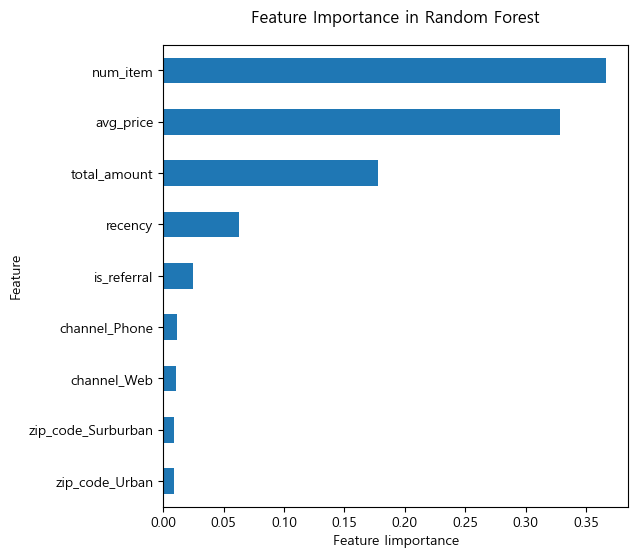

In [44]:
## Feature Importance 시각화
fig, ax = plt.subplots(figsize=(6, 6))

Series_feat_imp.sort_values(ascending=True).plot.barh()

plt.xlabel('Feature Iimportance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest', y=1.03)
plt.show()